# original.txtの中身を調べる

* すでに表記ゆれはある程度前処理されている
* original.txtからデータセットを作成する方法はいくつかある
* capoの方は、半音下げ(-1) ~ capo5(-5)までが大半を占めているので、6と7は削除でよさそう
* chordの方はいろいろある。低頻度のコードを削除する、何らかのコードで置き換えるなど
* とりあえず削除する方向で

In [19]:
from pathlib import Path
import sys,os
sys.path.append(os.pardir)
from tools.preprocess.common import CommonPreprocessor

In [20]:
orignal_path=Path("../data/original.txt")

In [21]:
cp=CommonPreprocessor(rare_capo_list=['-6', '-7'],val_rate=0.1,test_rate=0.2,split_seed=0)
songs=cp.get_song_list(orignal_path)
songs=cp.remove_rare_capo_song(songs)
songs_train, songs_valid, songs_test=cp.split_dataset(songs)

In [22]:
chord_stat=cp.retrieve_chord_stat(songs_train)
capo_stat=cp.retrieve_capo_stat(songs_train)

## chordの出現頻度調査
* 低頻度chordはparseミスとかも含むので除去したい
* 5回以下しか出現しない約140個のコードを対象？

Total chords :847


/Users/hikaru_ogura/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


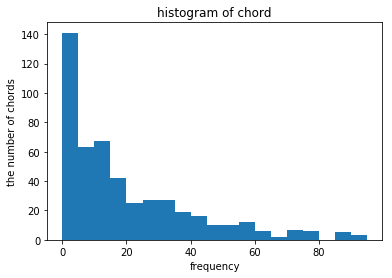

In [23]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Total chords :{len(chord_stat.keys())}")

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
edges = range(0,100,5)
ax.hist(list(chord_stat.values()), bins=edges)
ax.set_title('histogram of chord')
ax.set_xlabel('frequency')
ax.set_ylabel('the number of chords')
fig.show()